<a href="https://colab.research.google.com/github/sinajamshidi247/scientific--project/blob/master/matbench_expt_is_metal/expt_is_metal_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MODNet 'matbench_expt_is_metal' benchmarking

Matbench v0.1 test dataset for classifying metallicity from composition alone. Retrieved from Zhuo et al. supplementary information. Deduplicated according to composition, ensuring no conflicting reports were entered for any compositions (i.e., no reported compositions were both metal and nonmetal). For benchmarking w/ nested cross validation, the order of the dataset must be identical to the retrieved data; refer to the Automatminer/Matbench publication for more details.
Columns:
	composition: Chemical formula.
	is_metal: Target variable. 1 if is a metal, 0 if nonmetal.
Num Entries: 4921
Reference: Y. Zhuo, A. Masouri Tehrani, J. Brgoch (2018) Predicting the Band Gaps of Inorganic Solids by Machine Learning J. Phys. Chem. Lett. 2018, 9, 7, 1668-1673
 https//:doi.org/10.1021/acs.jpclett.8b00124.

In [1]:
from collections import defaultdict
import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown
from matminer.datasets import load_dataset
from pymatgen.core import Composition

from modnet.preprocessing import MODData
#from modnet.models import MODNetModel
from modnet.featurizers import MODFeaturizer
from modnet.featurizers.presets import DeBreuck2020Featurizer

os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
!pip install matminer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.1/809.1 kB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.2/788.2 kB 48.8 MB/s eta 0:00:00
  Created wheel for bibtexparser: filename=bibtexparser-1.4.3-py3-none-any.whl size=435

In [5]:
!pip -q install "numpy==1.26.4"



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 100.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
geopandas 1.1.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
inequality 1.1.2 requires pandas>=2.1, but you have pandas 1.5.3 which is incompatible.
spopt 0.7.0 requires pandas>=2.1.0, but you have pandas 1.5.3 which is incompatible.
thinc 8.3.10 requires pydantic<3.0.0,>=2.0.0, but you 

In [3]:
!pip install modnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 71.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 57.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of modnet to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 115.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 1.8 M

In [4]:
import pandas as pd
from pymatgen.core import Composition
from modnet.featurizers.presets import CompositionOnlyFeaturizer

f = CompositionOnlyFeaturizer()

df_test = pd.DataFrame({"composition": [Composition("Fe2O3"), Composition("SiO2")]})
df_feat = f.featurize_composition(df_test)

print("Num features:", df_feat.shape[1])
print(df_feat.columns[:30])   # feature names


KeyError: 'AtomicOrbitals|HOMO_character'

In [2]:
import modnet
modnet.__version__

'0.4.1'

In [ ]:
Markdown(filename="./README.md")

## Data exploration

In [6]:
df = load_dataset("matbench_expt_is_metal")
df["composition"] = df["composition"].map(Composition)

In [ ]:
df.columns

Index(['composition', 'is_metal'], dtype='object')

In [7]:
df.head(10)

,composition,is_metal
0,"(Ag, Au, S)",True
1,"(Ag, W, Br)",True
2,"(Ag, Ge, Pb, S)",False
3,"(Ag, Ge, Pb, Se)",False
4,"(Ag, B, Br)",True
5,"(Ag, Bi, O)",True
6,"(Ag, Ge, S)",False
7,"(Ag, Ge, Se)",False
8,"(Ag, Ge, Te)",False
9,"(Ag, Hg, I)",False


In [8]:
len(df)

4921

### Composition space

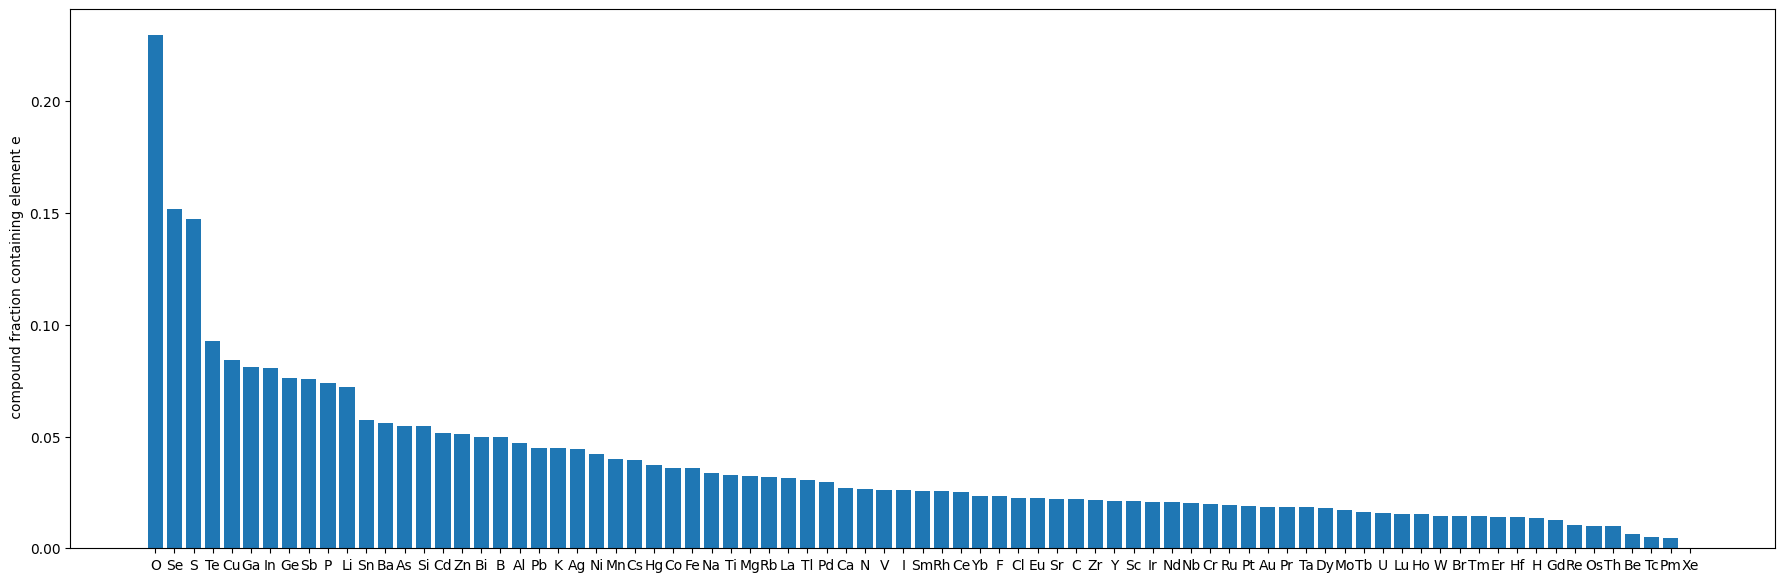

In [9]:
## /!\ the interpretation is different from the steels
values = df["composition"].apply(lambda s: s.get_el_amt_dict())
elements = defaultdict(float)
proportions = defaultdict(list)
for s in values:
    tot = np.sum(list(s.values()))
    for e in s:
        elements[e] += 1
        proportions[e] += [s[e]/tot]

for elem in elements:
    elements[elem] /= len(values)

mean_proportions = {elem: np.mean(proportions[elem]) for elem in proportions}
mean_proportions = dict(sorted(mean_proportions.items(), key=lambda x: x[1], reverse=True)) #compute average composition fraction per element
elements = dict(sorted(elements.items(), key=lambda x: x[1], reverse=True))

fig, ax = plt.subplots(facecolor="w",figsize=(22,7));
#ax.set_yscale("log")
ax.bar(elements.keys(), elements.values())
ax.set_ylabel(" compound fraction containing element e");

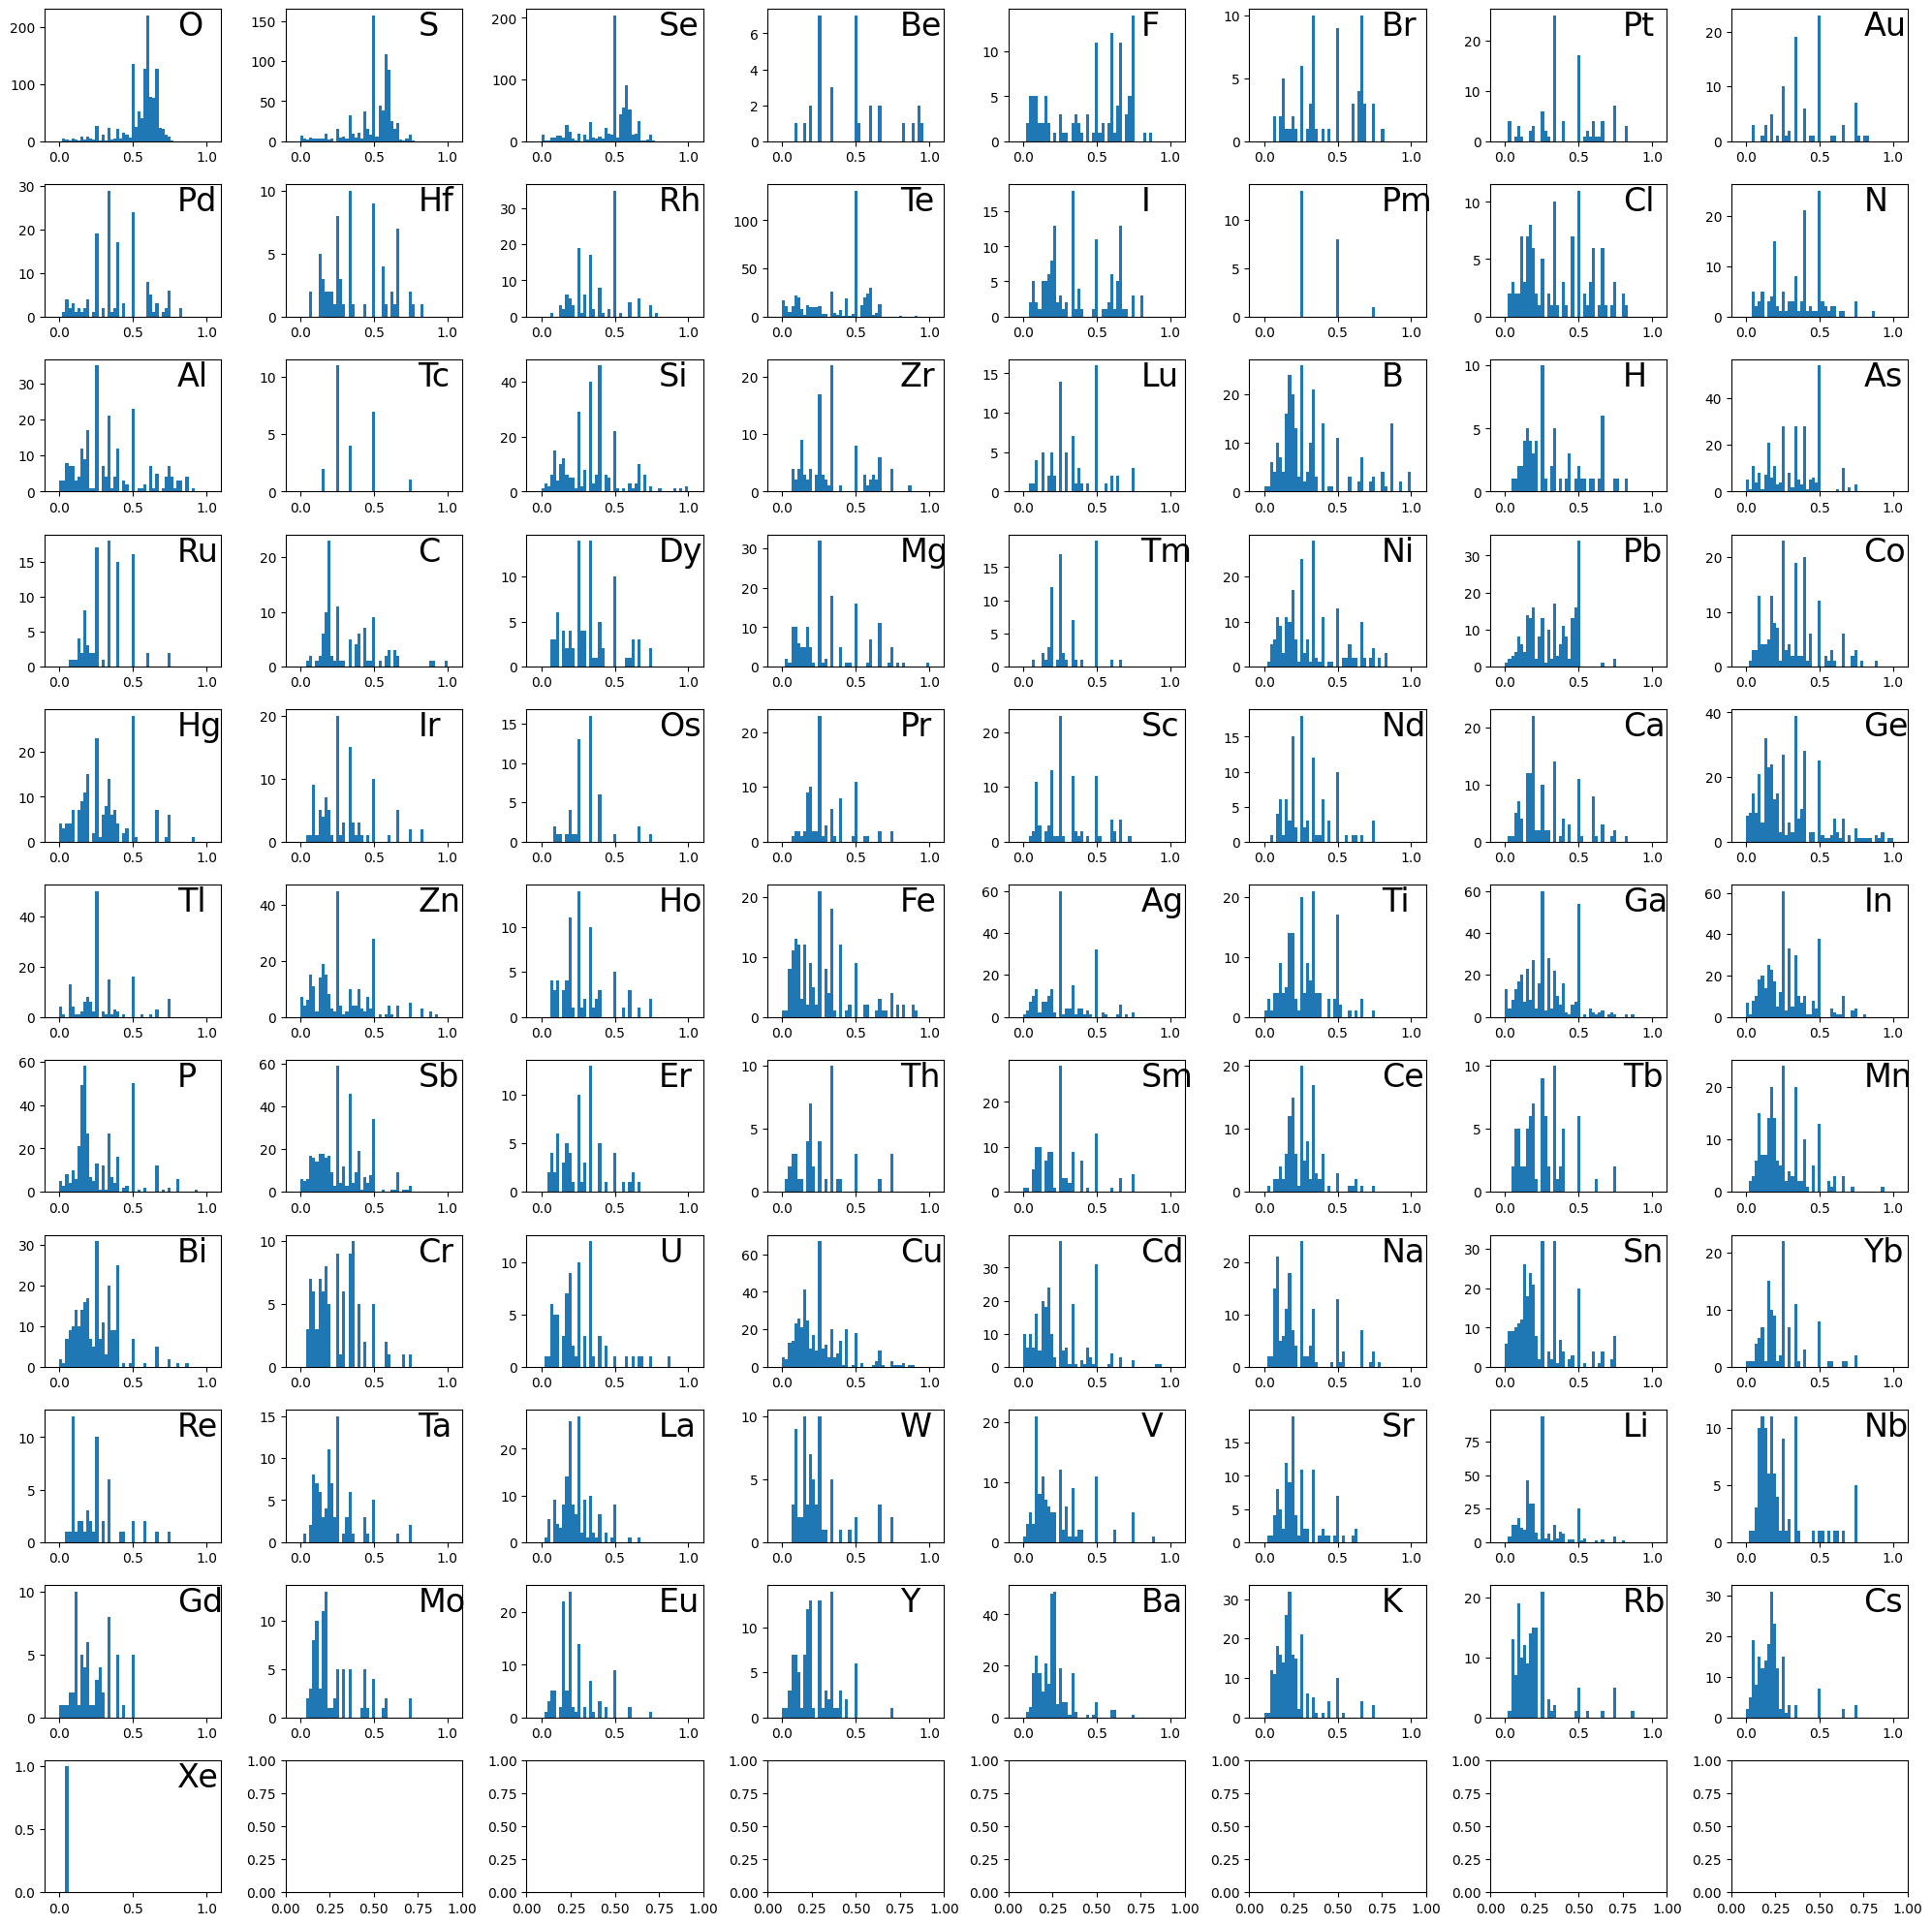

In [10]:
# distribution of element proportions across compositions
fig, axis = plt.subplots(11, 8, facecolor="w", figsize=(20, 20))
for ax, elem in zip(axis.flatten(), mean_proportions):
    ax.hist(
        proportions[elem],
        bins=np.linspace(0, 1, 50),
        density=False,
    )
    ax.set_xlim(-0.1, 1.1)
    ax.text(0.75, 0.8, elem, fontsize=24, transform=ax.transAxes, )
    #ax[axis].set_ylim(0, 312)

plt.tight_layout()

### Target space

In [11]:
df['is_metal'] = df['is_metal'].map(int)
df.describe()

,is_metal
count,4921.000000
mean,0.498069
std,0.500047
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
fig, ax = plt.subplots(facecolor="w")
ax.hist(df["is_metal"]);
ax.set_ylabel("Frequency")
ax.set_xlabel("is metal")

## Featurization and feature selection

First, we define some convenience classes that pass wraps composition data in a fake structure containe, and we define a composition only featurizer preset based on `DeBreuck2020Featurizer`.

In [12]:
class CompositionOnlyFeaturizer(MODFeaturizer):
    composition_featurizers = DeBreuck2020Featurizer.composition_featurizers

    def featurize_composition(self, df):
        """ Applies the preset composition featurizers to the input dataframe,
        renames some fields and cleans the output dataframe.

        """
        from pymatgen.core.periodic_table import Element
        import numpy as np
        from modnet.featurizers import clean_df
        df = super().featurize_composition(df)
        _orbitals = {"s": 1, "p": 2, "d": 3, "f": 4}
        df['AtomicOrbitals|HOMO_character'] = df['AtomicOrbitals|HOMO_character'].map(_orbitals)
        df['AtomicOrbitals|LUMO_character'] = df['AtomicOrbitals|LUMO_character'].map(_orbitals)

        df['AtomicOrbitals|HOMO_element'] = df['AtomicOrbitals|HOMO_element'].apply(
            lambda x: -1 if not isinstance(x, str) else Element(x).Z
        )
        df['AtomicOrbitals|LUMO_element'] = df['AtomicOrbitals|LUMO_element'].apply(
            lambda x: -1 if not isinstance(x, str) else Element(x).Z
        )

        df = df.replace([np.inf, -np.inf, np.nan], 0)

        return clean_df(df)

class CompositionContainer:
    def __init__(self, composition):
        self.composition = composition

In [25]:
import os, shutil

PRECOMPUTED_MODDATA = "./precomputed/expt_is_metal_benchmark_moddata.pkl.gz"

# 1) Remove broken cached file if it exists
if os.path.isfile(PRECOMPUTED_MODDATA):
    os.remove(PRECOMPUTED_MODDATA)
    print("Deleted cached MODData:", PRECOMPUTED_MODDATA)

# 2) Also remove the folder if it exists and you want a fully clean start (optional)
# shutil.rmtree("./precomputed", ignore_errors=True)


In [13]:

# Use a fresh copy of the dataset
df = load_dataset("matbench_expt_is_metal")
df["composition"] = df["composition"].map(Composition)
df["structure"] = df["composition"].map(CompositionContainer)

data = MODData(
    structures=df["structure"].tolist(),
    targets=df["is_metal"].tolist(),
    target_names=["is_metal"],
    featurizer=CompositionOnlyFeaturizer(n_jobs=8),
    num_classes = {'is_metal':2}
)
data.featurize()
# As this is a small data/feature set, order all features
# data.feature_selection(n=-1)

2025-12-15 19:03:25,050 - modnet - INFO - Loaded CompositionOnlyFeaturizer featurizer.


INFO:modnet:Loaded CompositionOnlyFeaturizer featurizer.


2025-12-15 19:03:25,065 - modnet - INFO - Computing features, this can take time...


INFO:modnet:Computing features, this can take time...


2025-12-15 19:03:25,072 - modnet - INFO - Data has successfully been featurized!


INFO:modnet:Data has successfully been featurized!


In [14]:
print(len(data.df_featurized.columns))
print(list(data.df_featurized.columns)[:30])


0
[]


In [17]:
data.df_featurized.shape


(0, 0)

In [18]:
print("Has df_featurized attr?", hasattr(data, "df_featurized"))
print("Has df_targets attr?  ", hasattr(data, "df_targets"))

df_feat = getattr(data, "df_featurized", None)
df_targ = getattr(data, "df_targets", None)

print("df_featurized is None?", df_feat is None)
print("df_targets is None?   ", df_targ is None)
print("df_featurized type:", type(df_feat))
print("df_targets type:   ", type(df_targ))

Has df_featurized attr? True
Has df_targets attr?   True
df_featurized is None? False
df_targets is None?    False
df_featurized type: <class 'pandas.core.frame.DataFrame'>
df_targets type:    <class 'pandas.core.frame.DataFrame'>


In [22]:
data.featurize()

2025-12-15 19:11:14,279 - modnet - INFO - Computing features, this can take time...


INFO:modnet:Computing features, this can take time...


RuntimeError: Not overwriting existing featurized dataframe.

In [23]:
print("df_featurized:", data.df_featurized.shape)


df_featurized: (0, 0)


In [ ]:
# Look at some of the top features chosen by MODNet
for feat in data.optimal_features[:10]:
    fig, ax = plt.subplots(facecolor="w")
    plt.scatter(data.df_featurized[feat], data.df_targets, alpha=0.5)
    plt.xlabel(feat)
    plt.ylabel("is_metal")

## Training

This is a very small dataset, so we must make judicious use of what data there is. First, let's generate test folds according to [matbench's suggestions](https://hackingmaterials.lbl.gov/automatminer/datasets.html#benchmarking-and-reporting-your-algorithm):

In [ ]:
try:
    plot_benchmark
except:
    import sys
    sys.path.append('..')
    from modnet_matbench.utils import *

In [ ]:
from sklearn.model_selection import KFold
#from modnet.models import MODNetModel
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

data.df_targets['is_metal'] = data.df_targets['is_metal'].map(int)

best_settings = {
    "increase_bs":False,
    "num_neurons": [[128], [32], [32], [16]],
    "n_feat": 120,
    "lr": 0.005, #0.005
    "epochs": 100,
    "verbose": 0,
    "act": "elu",
    "batch_size": 64,
    "num_classes": {'is_metal':2},
    "loss": "categorical_crossentropy",
    #"xscale": "standard",
}

results = matbench_benchmark(data, [[["is_metal"]]], {"is_metal": 1}, best_settings,classification=True, save_folds=True)
np.mean(results['scores'])

In [ ]:
for i,c in zip(range(5),['b','k','r','g','y']):
    plt.plot(results["models"][i].history.history["loss"][50:],c=c)
    #plt.plot(results["models"][i].history.history["val_loss"][50:],':',c=c)

## Feature selection

In [ ]:
model = results['models'][0]

In [ ]:
def process(data):
    x = data.get_featurized_df()[model.optimal_descriptors[:model.n_feat]]
    x = model._scaler.transform(x)
    x = np.nan_to_num(x)
    return x

In [ ]:
try:
    matbench_kfold_splits()
except:
    os.chdir("..")
    from modnet_matbench.utils import matbench_kfold_splits


In [ ]:
import shap
shap.initjs()
for train, test in matbench_kfold_splits(data):
    train_moddata, test_moddata = data.split((train, test))
    break

X_train = shap.sample(process(train_moddata))
explainer = shap.KernelExplainer(model.model.predict, X_train)

In [ ]:
shap_values = explainer.shap_values(X_train, nsamples=1000)

In [ ]:
shap.force_plot(
    explainer.expected_value[0],
    shap_values[0],
    feature_names=model.optimal_descriptors[:model.n_feat],
    out_names=["is_not_metal"],
)

In [ ]:
shap.summary_plot(shap_values[0], X_train, max_display=32, plot_type="dot", feature_names=model.optimal_descriptors[:model.n_feat])